In [1]:
import copy
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
from matplotlib.animation import FuncAnimation
from tqdm.auto import tqdm, trange

sys.path.append("..")
from model import Model
from preprocess import preprocess
from scheduler import CosineScheduler
from trainer import train_bc, train_ic, train_pde_data, validate

from burgers.plot import plot_2d
from neural_rk.modules import count_trainable_param
from neural_rk.path import DATA_DIR, FIG_DIR

rng = np.random.default_rng(42)
device = torch.device("cuda:0")

# Data
### Notations
- $N_x$: Number of grid points at x-axis
- $N_y$: Number of grid points at y-axis
- $N$: number of all grid points. e.g., for 2D square lattice, $N = N_x * N_y$
- $E$: number of edges. e.g., for 2D square lattice with periodic B.C., $E = 2 * N$
- $S$: number of time steps

### Grid to Graph mapping
<pre>
3 -- 4 -- 5
|    |    |
0 -- 1 -- 2
</pre>
node: 0, 1, 2, 3, 4, 5

edge: (0, 1), (0, 3), (1, 2), (1, 4), (2, 5), (2, 0), (3, 4), (3, 0), (4, 5), (4, 1), (5, 3), (5, 2)


### Values of dataframe
- Optimized for GNN. Need to do pre-processing for others
- All values except network_type are torch.Tensor type with float32 precision

1. network_type: Nx_Ny. e.g., 100_100 if N_x=100 and N_y=100
2. edge_index: [2, $E$], which node is connected to which node
3. node_attr: [$N$, 2], all ones. If 1D burgers equation, node_attr[:, 1] = 0
4. edge_attr: [$E$, 2], distance of each edges.\
   edge_attr[:, 0]: nonzero for x-axis edge, edge_attr[:, 1]: nonzero for y-axis edge
5. glob_attr: [1, 2], [[nu, nu]] where nu is diffusion term of burgers equation.\
   If 1D burgers equation, [[nu, 0]]
6. dts: [$S$, 1], dt of each time step
7. trajectories: [$S+1$, $N$, 2], u, v value of each time step, each node. Length is $S+1$ since it contains initial condition

In [2]:
test_id = "IC_train"
sample_idx = 0
exp_id = "PINN"

df = pd.read_pickle(DATA_DIR / f"burgers_dirichlet_{test_id}.pkl")
data = df.iloc[sample_idx]
data

network_type                                              100_100
edge_index      [[tensor(0), tensor(0), tensor(1), tensor(1), ...
node_attr       [[tensor(0.), tensor(0.)], [tensor(0.), tensor...
edge_attr       [[tensor(0.0101), tensor(0.)], [tensor(0.), te...
glob_attr                      [[tensor(0.0100), tensor(0.0100)]]
dts             [[tensor(0.0010)], [tensor(0.0010)], [tensor(0...
trajectories    [[[tensor(0.), tensor(0.)], [tensor(0.), tenso...
Name: 0, dtype: object

# PINN
#### NOTE : Full-batch training

In [3]:
xyt, true_field, nu = preprocess(data)  # Change to grid format
# xyt = xyt[:, :, :int(xyt.shape[2] / 2), :]
# true_field = true_field[:int(true_field.shape[0] / 2), ...]

# batch size
ic_sparsity = 1.0  # Sparsity of choosing grid points for initial condition
bc_sparsity = 0.1  # Sparsity of choosing grid points for boundary condition
pde_sparsity = 0.04  # Sparsity of choosing grid points for PDE condition
data_sparsity = 0.04  # Sparsity of choosing grid points for data condition
val_sparsity = 0.1  # Sparsity of choosing grid points for validation

# Full data
# Initial condition
ic_xyt = xyt[..., 0, :]
ic_x = ic_xyt[..., 0].reshape(-1, 1)
ic_y = ic_xyt[..., 1].reshape(-1, 1)
ic_t = ic_xyt[..., 2].reshape(-1, 1)
ic_field = true_field[0].reshape(-1, 2)
num_ic = int(ic_sparsity * len(ic_x))

# Boundary condition
bc_xyt = torch.cat((xyt[0, :, ...], xyt[-1, :, ...], xyt[:, 0, ...], xyt[:, -1, ...]), dim=0)
bc_x = bc_xyt[..., 0].reshape(-1, 1)
bc_y = bc_xyt[..., 1].reshape(-1, 1)
bc_t = bc_xyt[..., 2].reshape(-1, 1)
num_bc = int(bc_sparsity * len(bc_x))

# PDE, data condition
pde_xyt = xyt[1:-1, 1:-1, ...]
pde_x = pde_xyt[..., 0].reshape(-1, 1)
pde_y = pde_xyt[..., 1].reshape(-1, 1)
pde_t = pde_xyt[..., 2].reshape(-1, 1)
pde_field = true_field[:, 1:-1, 1:-1, ...].reshape(-1, 2)
num_pde = int(pde_sparsity * len(pde_x))

# Validation
val_x = xyt[..., 0].reshape(-1, 1)
val_y = xyt[..., 1].reshape(-1, 1)
val_t = xyt[..., 2].reshape(-1, 1)
val_field = true_field.reshape(-1, 2)
num_val = int(val_sparsity * len(val_x))


In [4]:
import torch.nn as nn
class Model2(nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__()
        self.m1 = Model(out_dim=1, **kwargs)
        self.m2 = Model(out_dim=1, **kwargs)

    def forward(self, x, y, t):
        return torch.cat([self.m1(x, y, t), self.m2(x, y, t)], dim=-1)

# model = Model2(hidden_dim=64).to(device)
model = Model(hidden_dim=32, depth=3, act="sigmoid", bn_momentum=0.1).to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = CosineScheduler(
    optimizer, lr_max=1e-3, period=200, warmup=0, lr_max_mult=0.5, period_mult=2.0
)

print(f"Trainable parameters: {count_trainable_param(model)}")
print(f"Number of initial condtion points: {num_ic}")
print(f"Number of boundary condtion points: {num_bc}")
print(f"Number of pde points: {num_pde}")
print(f"Number of data points: {num_pde}")

Trainable parameters: 1312
Number of initial condtion points: 10000
Number of boundary condtion points: 40040
Number of pde points: 384544
Number of data points: 384544


In [5]:
# epochs = []
# lrs = []
# scheduler = CosineScheduler(
#     optimizer, lr_max=1e-1, period=200, warmup=0, lr_max_mult=0.5, period_mult=2.0
# )
# for epoch in range(3000):
#     epochs.append(epoch)
#     lrs.append(optimizer.param_groups[0]["lr"])
#     scheduler.step()

# plt.plot(epochs, lrs)

In [6]:
epochs = 3000

losses_ic: list[float] = []
losses_bc: list[float] = []
losses_pde: list[float] = []
losses_data: list[float] = []
losses_train: list[float] = []
losses_test: list[float] = []

best_val_loss = 99999999.0
best_model_state_dict = copy.deepcopy(model.state_dict())

for epoch in trange(epochs):
    model.train()

    # Initial condition
    loss_ic = train_ic(model, ic_x, ic_y, ic_t, ic_field, num_ic, device, rng)

    # Boundary condition
    loss_bc = train_bc(model, bc_x, bc_y, bc_t, num_bc, device, rng)

    # PDE, data condition
    loss_pde, loss_data = train_pde_data(model, pde_x, pde_y, pde_t, pde_field, num_pde, nu, device, rng)

    # Combining the loss functions
    loss = (
        0.0 * loss_ic
        + 0.0 * loss_bc
        + 0.0 * loss_pde
        + 1.0 * loss_data
    )

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Validation
    model.eval()
    loss_val = validate(model, val_x, val_y, val_t, val_field, num_val, device, rng).item()

    losses_ic.append(loss_ic.item())
    losses_bc.append(loss_bc.item())
    losses_pde.append(loss_pde.item())
    losses_data.append(loss_data.item())
    losses_train.append(loss.item())
    losses_test.append(loss_val)

    # Save best model
    if loss_val >= best_val_loss or epoch < 100:
        continue
    best_val_loss = loss_val
    best_model_state_dict = copy.deepcopy(model.state_dict())
    tqdm.write(f"{epoch}: train loss={loss.item():.4e}, val loss={loss_val:.4e}")

# Load best model state
last_model_state_dict = copy.copy(model.state_dict())
model.load_state_dict(best_model_state_dict)

  0%|          | 0/3000 [00:00<?, ?it/s]

100: train loss=3.9791e-02, val loss=3.8374e-02
101: train loss=4.0036e-02, val loss=3.8290e-02
106: train loss=3.9693e-02, val loss=3.8260e-02
107: train loss=3.9802e-02, val loss=3.8206e-02
118: train loss=3.9589e-02, val loss=3.8100e-02
173: train loss=3.9922e-02, val loss=3.8028e-02


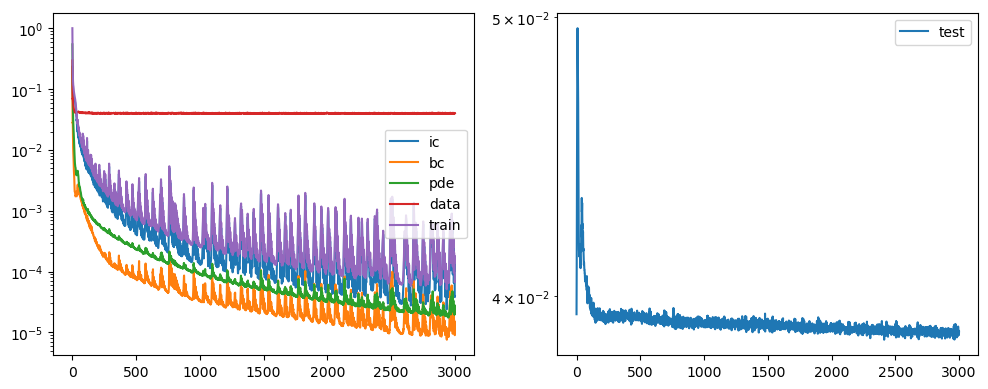

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), ncols=2)

ax1.plot(losses_ic, label="ic")
ax1.plot(losses_bc, label="bc")
ax1.plot(losses_pde, label="pde")
ax1.plot(losses_data, label="data")
ax1.plot(losses_train, label="train")

ax1.legend()
ax1.set_yscale("log")

ax2.plot(losses_test, label="test")
ax2.legend()
ax2.set_yscale("log")

fig.tight_layout()
fig.show()

In [ ]:
# exp_id = 2
# result_dir = Path("result") / f"{exp_id}"

# result_dir.mkdir()
# checkpoint = {
#     "best_model_state_dict": model.state_dict(),
#     "ic": losses_ic,
#     "bc": losses_bc,
#     "pde": losses_pde,
#     "data": losses_data,
#     "train": losses_train,
#     "test": losses_test,
# }
# torch.save(checkpoint, result_dir / "model.pth")


# checkpoint = torch.load(result_dir / "model.pth")
# model.load_state_dict(checkpoint["best_model_state_dict"])
# losses_ic = checkpoint["ic"]
# losses_bc = checkpoint["bc"]
# losses_pde = checkpoint["pde"]
# losses_data = checkpoint["data"]
# losses_train = checkpoint["train"]
# losses_test = checkpoint["test"]

# Test

In [ ]:
model.load_state_dict(last_model_state_dict)

<All keys matched successfully>

In [8]:
num_batch = 4
num_steps, Ny, Nx, _ = true_field.shape  # [S+1, Ny, Nx]

pred_trajectories = []
with torch.no_grad():
    model.eval()

    for batch in range(num_batch):
        start = int(num_steps / num_batch * batch)
        end = int(num_steps / num_batch * (batch + 1)) if batch < num_batch - 1 else num_steps

        xyt_batch = xyt[:, :, start:end].reshape(-1, 3, 1).to(device)
        prediction = model(xyt_batch[:, 0], xyt_batch[:, 1], xyt_batch[:, 2])

        # [Ny, Nx, batch_step, 2]
        pred_trajectories.append(prediction.reshape(Ny, Nx, -1, 2))

# [S+1, Ny, Nx, 2]
pred_trajectory = torch.cat(pred_trajectories, dim=2).permute(2, 0, 1, 3).cpu().numpy()
true_trajectory = true_field.cpu().numpy()

In [9]:
error = true_trajectory - pred_trajectory
print(f"MAE={np.abs(error).mean():.4e}, in range {error.min(), error.max()}")

MAE=1.3525e-01, in range (-0.98344654, 0.9656889)


In [11]:
# zero prediction
print(f"MAE={np.abs(true_trajectory).mean():.4e}, in range {true_trajectory.min(), true_trajectory.max()}")

MAE=1.2930e-01, in range (-1.0, 1.0)


In [ ]:
# Best overall
error = true_trajectory - pred_trajectory
print(f"MAE={np.abs(error).mean():.4e}, in range {error.min(), error.max()}")

MAE=8.0588e-02, in range (-0.41972405, 0.49775845)


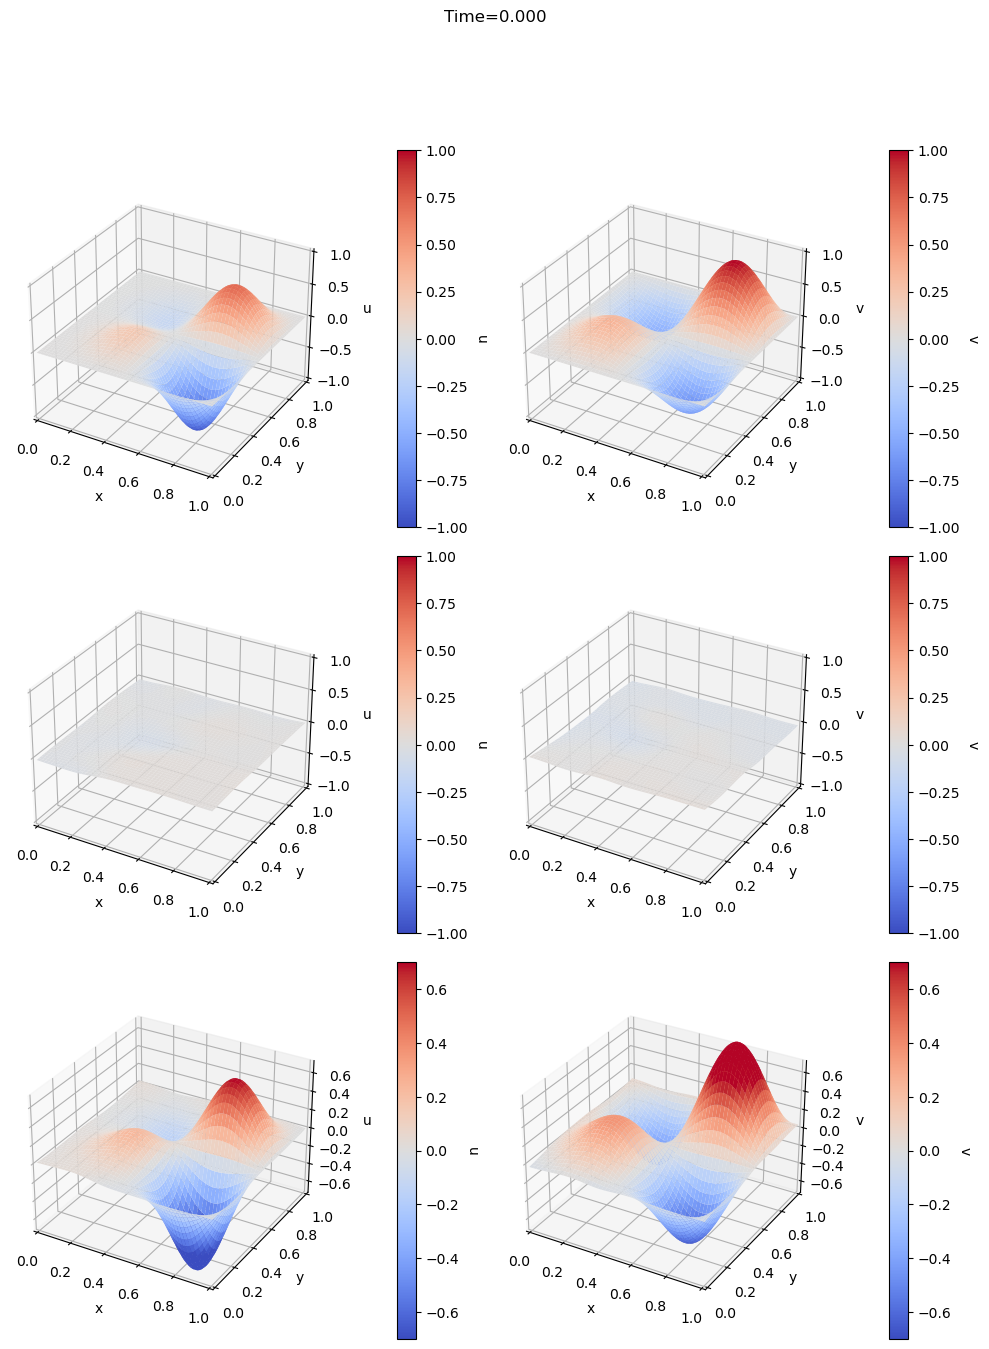

In [14]:
skip_frame = 10
position = xyt[:, :, 0, :2].numpy()
time = xyt[0, 0, :, 2].numpy()

fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(321, projection="3d")
ax2 = fig.add_subplot(322, projection="3d")
ax3 = fig.add_subplot(323, projection="3d")
ax4 = fig.add_subplot(324, projection="3d")
ax5 = fig.add_subplot(325, projection="3d")
ax6 = fig.add_subplot(326, projection="3d")

ax1.set_title("True")
sf1, sf2 = plot_2d(ax1, ax2, position, true_trajectory[0], to_periodic=False)
cbar1 = ax1.figure.colorbar(sf1, ax=ax1, shrink=0.6, pad=0.15)
cbar1.ax.set_ylabel("u", rotation=-90, va="bottom")
cbar2 = ax2.figure.colorbar(sf2, ax=ax2, shrink=0.6, pad=0.15)
cbar2.ax.set_ylabel("v", rotation=-90, va="bottom")


ax3.set_title("Pred")
sf3, sf4 = plot_2d(ax3, ax4, position, pred_trajectory[0], to_periodic=False)
cbar3 = ax3.figure.colorbar(sf3, ax=ax3, shrink=0.6, pad=0.15)
cbar3.ax.set_ylabel("u", rotation=-90, va="bottom")
cbar4 = ax4.figure.colorbar(sf4, ax=ax4, shrink=0.6, pad=0.15)
cbar4.ax.set_ylabel("v", rotation=-90, va="bottom")

ax5.set_title("Error")
sf5, sf6 = plot_2d(ax5, ax6, position, error[0], to_periodic=False, lim=(-0.7, 0.7))
cbar5 = ax5.figure.colorbar(sf5, ax=ax5, shrink=0.6, pad=0.15)
cbar5.ax.set_ylabel("u", rotation=-90, va="bottom")
cbar6 = ax6.figure.colorbar(sf6, ax=ax6, shrink=0.6, pad=0.15)
cbar6.ax.set_ylabel("v", rotation=-90, va="bottom")
fig.tight_layout()


def update(frame: int) -> None:
    frame *= skip_frame
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    ax5.clear()
    ax6.clear()
    plot_2d(ax1, ax2, position, true_trajectory[frame], to_periodic=False)
    plot_2d(ax3, ax4, position, pred_trajectory[frame], to_periodic=False)
    plot_2d(ax5, ax6, position, error[frame], to_periodic=False, lim=(-0.7, 0.7))
    fig.suptitle(f"Time={time[frame]:.3f}")
    fig.tight_layout()


anim = FuncAnimation(
    fig, update, frames=int(len(pred_trajectory) / skip_frame), interval=50
)
# anim.save(str(FIG_DIR / f"burgers_dirichlet_{test_id}_{sample_idx}_{exp_id}.gif"))
anim.save("temp.gif")